In [650]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import tempfile

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_validate
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score,log_loss,plot_confusion_matrix,confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from tensorflow import keras
import tensorflow as tf

%matplotlib inline

## Feature Selection and Model Selection

In [651]:
train = pd.read_csv('data/train.csv')

In [652]:
train.columns

Index(['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Payment Plan', 'Loan Title', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Accounts Delinquent', 'Total Collection Amount',
       'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

## Exploratory Data Analysis

In [653]:
na = pd.DataFrame(train.isnull().sum(),columns =['cnt'])
na[na['cnt'] > 0]

,cnt


In [654]:
train.head(10)

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.362860,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.996920,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.224550,59,BAT2136391,12.545884,F,D4,MORTGAGE,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.155850,59,BAT2428731,16.731201,C,C3,MORTGAGE,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.926670,59,BAT5341619,15.008300,C,D4,MORTGAGE,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0
5,50509046,34631,30203,8635.931613,36,BAT4694572,17.246986,B,G5,RENT,...,5.043575,0.581688,0,INDIVIDUAL,32,0,42,51252,27480,0
6,32737431,30844,19773,15777.511830,59,BAT4808022,10.731432,C,C5,RENT,...,3.167937,0.553076,0,INDIVIDUAL,71,0,3388,42069,31068,0
7,63151650,20744,10609,7645.014802,58,BAT2558388,13.993688,A,A5,OWN,...,0.098448,0.047589,0,INDIVIDUAL,87,0,48,184909,43303,0
8,4279662,9299,11238,13429.456610,59,BAT5341619,11.178457,G,C2,MORTGAGE,...,0.530214,0.216985,0,INDIVIDUAL,144,0,26,68126,7482,0
9,4431034,19232,8962,7004.097481,58,BAT2078974,5.520413,C,B5,RENT,...,2.912215,0.886864,0,INDIVIDUAL,9,0,35,71650,14871,0


In [655]:
train['Loan Status'].value_counts()

0    61222
1     6241
Name: Loan Status, dtype: int64

/Users/rajagopalps/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

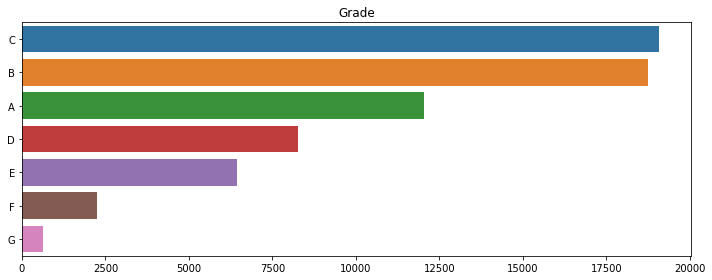

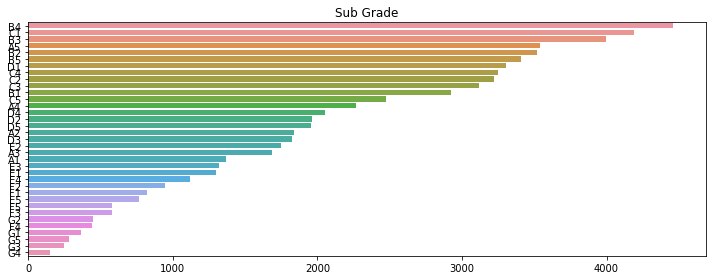

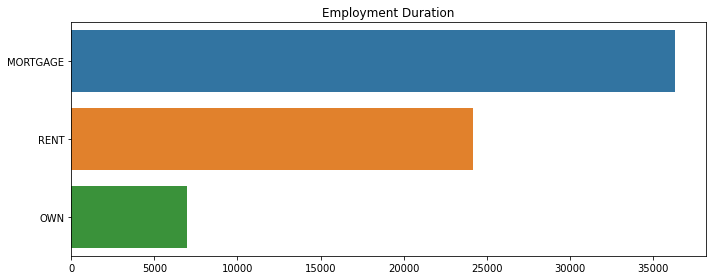

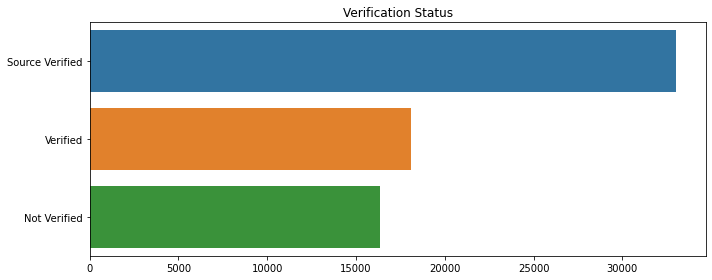

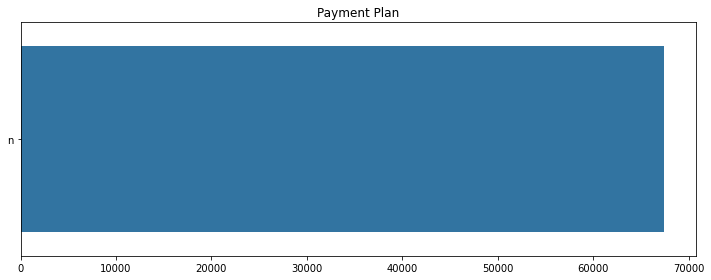

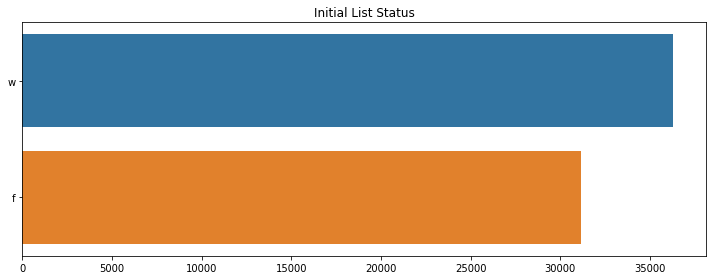

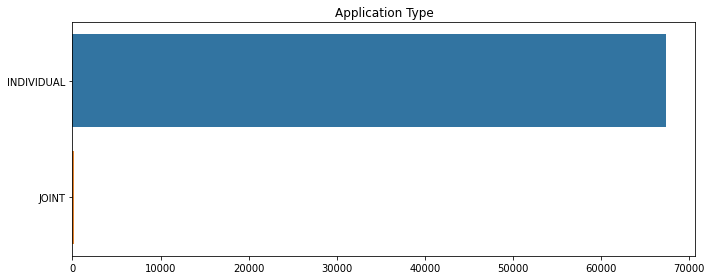

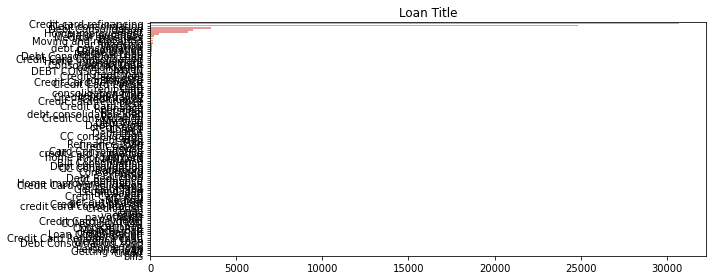

In [656]:
categorical_columns = [ 'Grade', 'Sub Grade', 'Employment Duration', 'Verification Status', 'Payment Plan', 'Initial List Status', 'Application Type','Loan Title']
for col in categorical_columns:
    plt.figure(figsize=(10,4))
    sns.barplot(train[col].value_counts().values,train[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

/Users/rajagopalps/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

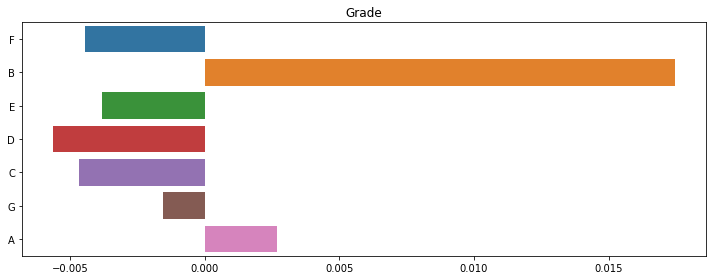

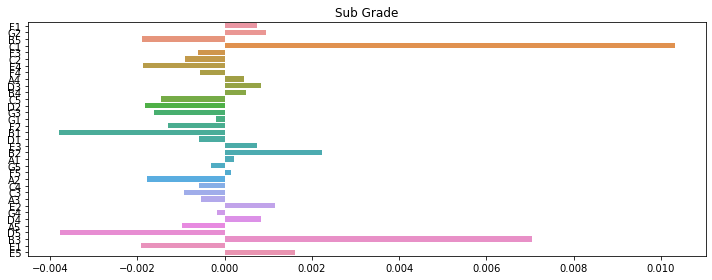

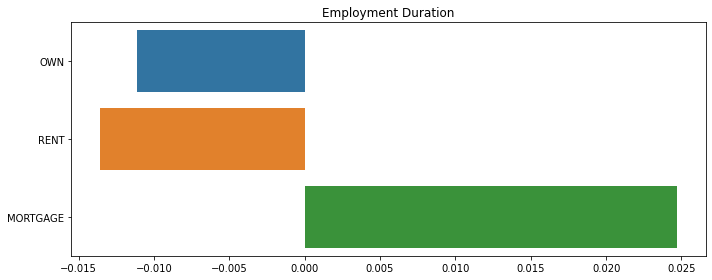

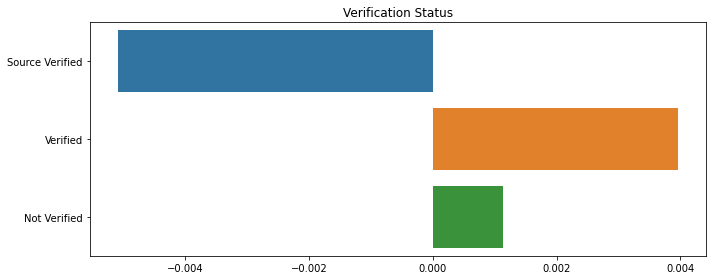

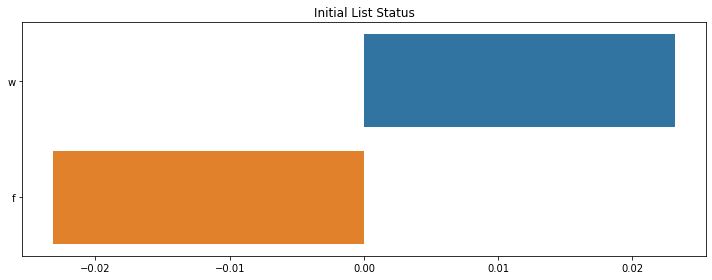

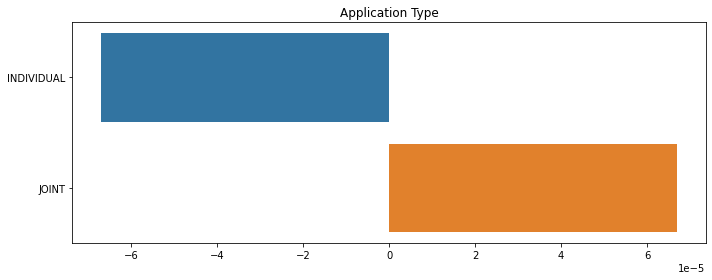

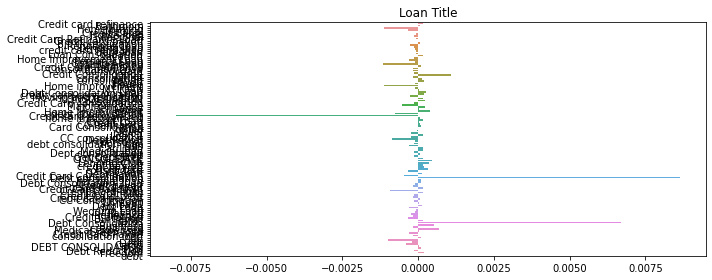

In [657]:
categorical_columns = [ 'Grade', 'Sub Grade', 'Employment Duration', 'Verification Status',  'Initial List Status', 'Application Type','Loan Title']
for col in categorical_columns:
    plt.figure(figsize=(10,4))
    non_defaulters=train.loc[train["Loan Status"] == 0,col].value_counts()
    defaulters=train.loc[train["Loan Status"] == 1,col].value_counts()
    all_counts = list(set(list(non_defaulters.index)+list(defaulters.index)))
    
    freq_non_defaulters = (train["Loan Status"] == 0).sum()
    freq_defaulters = (train["Loan Status"] == 1).sum()
    
    non_defaulters = non_defaulters.to_dict()
    defaulters = defaulters.to_dict()
    
    all_index = list(all_counts)
    all_counts = [non_defaulters.get(k,0)/freq_non_defaulters - defaulters.get(k,0)/freq_defaulters  for k in all_counts]

 
    sns.barplot(all_counts,all_index)
    plt.title(col)
    plt.tight_layout()

In [658]:
def dummy_column(col_name, df):
    temp_df = pd.get_dummies(df[col_name],prefix_sep='_',prefix=col_name, drop_first=True)
    temp_df = pd.concat([df,temp_df],axis=1)
    return temp_df.drop(col_name,axis=1)

In [659]:
train_dummies = train.drop(['Payment Plan','ID','Batch Enrolled'],axis=1)
for col in categorical_columns:
    train_dummies = dummy_column(col,train_dummies)

In [660]:
corr = train_dummies.corr()

<AxesSubplot:>

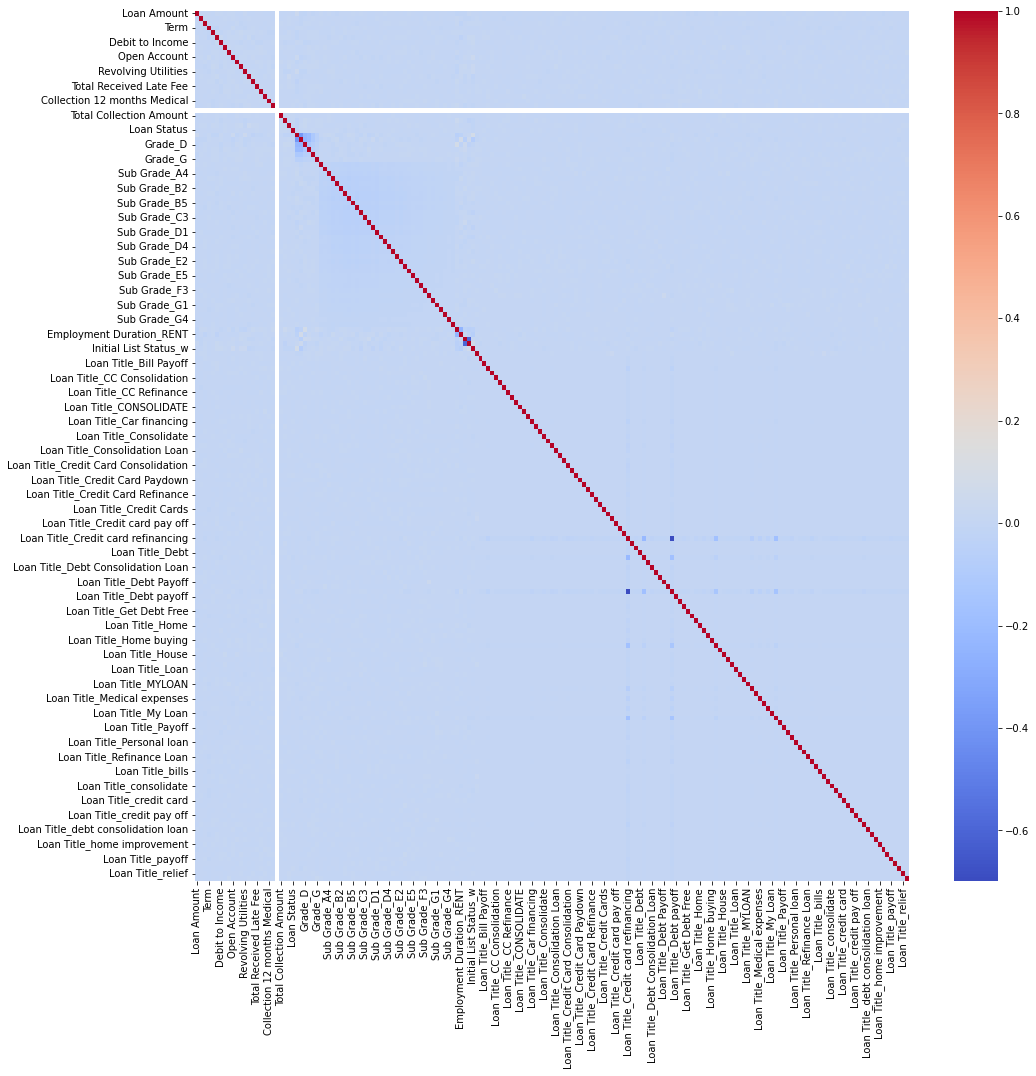

In [661]:
plt.figure(figsize=(16, 16))
sns.heatmap(corr, cmap = 'coolwarm')

In [662]:
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(np.bool))
corr_triu = corr_triu.stack()
corr_triu[corr_triu < -0.2]

Grade_B                              Grade_C                         -0.389558
                                     Grade_D                         -0.231653
                                     Grade_E                         -0.201590
Grade_C                              Grade_D                         -0.234590
                                     Grade_E                         -0.204146
Employment Duration_OWN              Employment Duration_RENT        -0.253300
Verification Status_Source Verified  Verification Status_Verified    -0.592682
Loan Title_Credit card refinancing   Loan Title_Debt Consolidation   -0.215357
                                     Loan Title_Debt consolidation   -0.698224
dtype: float64

In [663]:
corr_triu[corr_triu > 0.1]

Series([], dtype: float64)

### Observations
* Target Variable has imbalanced classess (defaulters are 10%, while 90% of dataset are non defaulters)
* No missing values (Clean dataset)
* Based on normalized relative frequency, the following categories are not likely to default
    * Grade B & A 
    * Employment Duration: Mortgage
    * Verification Status : Verified and Not Verified
    * Initial List Status: waiting
    * Application Type: Joint
* Dropped the column Payment Plan  as is only N for all rows
* Dropped the columns ID, Batch Enrolled as these are generated ids
* Very less correlation between input and output variables
* Even within input variables, there is correlation only between created dummy variables

## Baseline Accuracy

In [664]:
X = train.loc[ : , train.columns != 'Loan Status']
y = train['Loan Status']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43,stratify=y)

In [665]:
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.9075075965315349

In [666]:
def preprocess(train):
    train_copy = train.drop(['Payment Plan','ID','Batch Enrolled'],axis=1)
    categorical = [ 'Grade', 'Sub Grade', 'Employment Duration', 'Verification Status',  'Initial List Status', 'Application Type','Loan Title']
    for col in categorical:
        train_copy = dummy_column(col,train_copy)
    return train_copy

In [667]:
train_copy = preprocess(train)

## Feature Importances

In [668]:
X = train_copy.loc[ : , train_copy.columns != 'Loan Status']
y = train_copy['Loan Status']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43,stratify=y)

In [669]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

In [670]:
accuracy_score(y_test,y_pred)

0.9075075965315349

In [671]:
cols = list(train_copy.columns)
cols.remove('Loan Status')

In [672]:
importance = pd.DataFrame()
importance['features'] = cols
importance['score'] = rf_model.feature_importances_

In [673]:
features = list(importance[importance['score'] >= 0.01]['features'])
features

['Loan Amount',
 'Funded Amount',
 'Funded Amount Investor',
 'Interest Rate',
 'Home Ownership',
 'Debit to Income',
 'Delinquency - two years',
 'Open Account',
 'Revolving Balance',
 'Revolving Utilities',
 'Total Accounts',
 'Total Received Interest',
 'Total Received Late Fee',
 'Recoveries',
 'Collection Recovery Fee',
 'Last week Pay',
 'Total Collection Amount',
 'Total Current Balance',
 'Total Revolving Credit Limit']

## Handling Class imbalance

In [674]:
X = train_copy.loc[:, train_copy.columns != 'Loan Status']
y = train_copy['Loan Status']
sm = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=43)
X, y = sm.fit_resample(X, y)

## Xgboost with PCA

In [675]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43,stratify=y)

In [676]:
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
pca.explained_variance_ratio_.sum()

0.9979082569697332

In [677]:
def build_model():
    xgb_model = XGBClassifier(use_label_encoder=False,
                          n_jobs=-1)
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    print("Accuracy:",accuracy_score(y_test,y_pred))
    y_classes = xgb_model.predict_proba(X_test)
    print("Log Loss:",log_loss(y_test,y_classes))
    return xgb_model

[11:57:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.6910041243007065
Log Loss: 0.5877435677128746


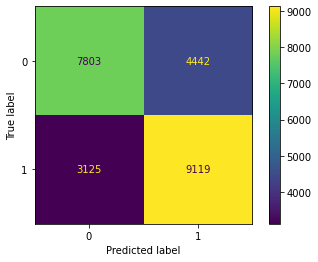

In [678]:
xgb_model = build_model()
plot_confusion_matrix(xgb_model, X_test, y_test)

## XGBoost for all features

In [679]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43,stratify=y)

[11:57:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9344603699620238
Log Loss: 0.2255721559680626


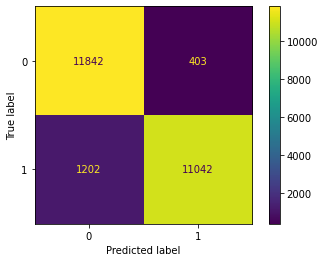

In [680]:
xgb_model = build_model()
plot_confusion_matrix(xgb_model, X_test, y_test)

## Keras

In [681]:
X = train_copy.loc[ : , train_copy.columns != 'Loan Status']
y = train_copy['Loan Status']
sc = StandardScaler()
X = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43,stratify=y)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=43,stratify=y_train)

In [682]:
neg = len(np.where(y_train ==0)[0])
pos = len(np.where(y_train ==1)[0])
total = pos+neg
initial_bias = np.log([pos/neg])

In [683]:
def build_model():

    METRICS = [
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.AUC(name='auc'),
          keras.metrics.Precision(name='prc'),
    ]

    nn_model = keras.models.Sequential()
    nn_model.add(keras.layers.Dense(32, activation='relu',input_dim=X_train.shape[1]))
    nn_model.add(keras.layers.Dense(16,activation ='relu'))
    nn_model.add(keras.layers.Dense(1,activation ='sigmoid', bias_initializer = keras.initializers.Constant(initial_bias)))
    nn_model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)

    print(nn_model.summary())
    return nn_model

In [684]:
nn_model = build_model()
callback = keras.callbacks.EarlyStopping(monitor='val_prc', patience=3, mode='max',restore_best_weights=True)
history = nn_model.fit(x=X_train, y=y_train, epochs=25,  validation_data=(X_val, y_val), shuffle=False,verbose=0)

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_245 (Dense)           (None, 32)                5728      
                                                                 
 dense_246 (Dense)           (None, 16)                528       
                                                                 
 dense_247 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________
None


In [685]:
def plot_history(history):
    for label in ['accuracy','loss','prc']:
        plt.plot(history.history[label])
        plt.plot(history.history[f'val_{label}'])
        plt.title(f'Model {label}')
        plt.ylabel(label)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

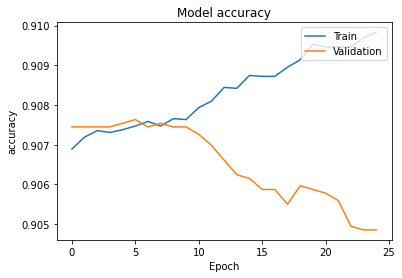

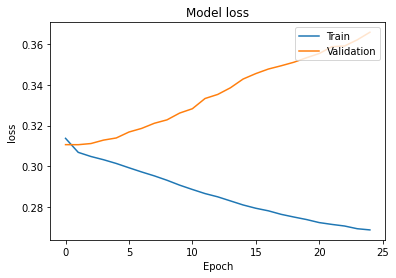

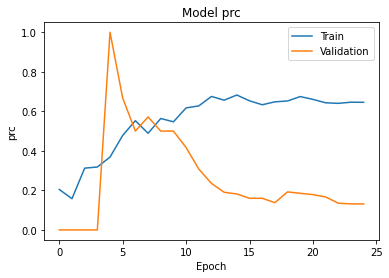

In [686]:
plot_history(history)

In [687]:
def evaluate_model(nn_model,p=0.5):
    results = nn_model.evaluate(X_test, y_test, verbose=0)
    print("Loss: {:0.4f}".format(results[0]))
    y_pred = nn_model.predict(X_test) 
    y_classes = y_pred.argmax(axis=-1)
    print("Log Loss: {:0.4f}".format(log_loss(y_test,y_classes)))
    cm = confusion_matrix(y_test, y_pred > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Loss: 0.3666
Log Loss: 3.1946


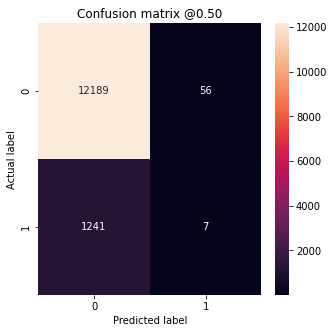

In [688]:
evaluate_model(nn_model)

## Weighted Model

In [689]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
nn_model.save_weights(initial_weights)

In [690]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

In [691]:
weighted_model = build_model()
weighted_model.load_weights(initial_weights)
callback = keras.callbacks.EarlyStopping(monitor='val_prc', patience=3, mode='max',restore_best_weights=True)
weighted_history = weighted_model.fit(x=X_train, y=y_train, epochs=25,  validation_data=(X_val, y_val), shuffle=False,verbose=0,class_weight=class_weight)

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_248 (Dense)           (None, 32)                5728      
                                                                 
 dense_249 (Dense)           (None, 16)                528       
                                                                 
 dense_250 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________
None


Loss: 0.6450
Log Loss: 3.1946


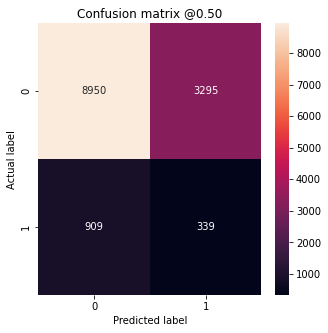

In [692]:
evaluate_model(weighted_model,0.5)

## Oversampling to Balance Classes

In [693]:
ds = pd.DataFrame(X_train)
ds["Loan Status"] = y_train
non_defaulters = ds[ds["Loan Status"] == 0]
defaulters = ds[ds["Loan Status"] == 1]

In [694]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

non_defaulters_ds = make_ds(non_defaulters.drop("Loan Status",axis=1), non_defaulters["Loan Status"])
defaulters_ds = make_ds(defaulters.drop("Loan Status",axis=1), defaulters["Loan Status"])

In [695]:
resampled_ds = tf.data.Dataset.sample_from_datasets([non_defaulters_ds, defaulters_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(1024).prefetch(2)

In [696]:
callback = keras.callbacks.EarlyStopping(monitor='val_prc', patience=3, mode='max',restore_best_weights=True)
resampled_model = build_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=300,
    callbacks=[callback],
    validation_data=(X_val, y_val),
    verbose=0)


Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 32)                5728      
                                                                 
 dense_252 (Dense)           (None, 16)                528       
                                                                 
 dense_253 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________
None


Loss: 0.8712
Log Loss: 3.1946


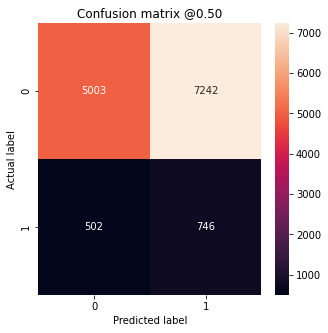

In [697]:
evaluate_model(resampled_model)

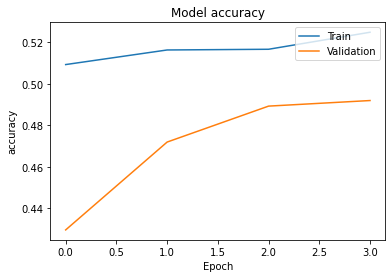

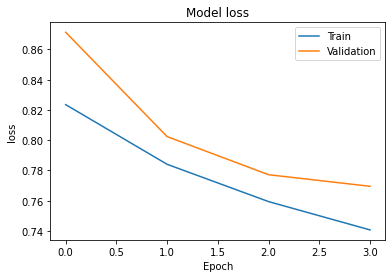

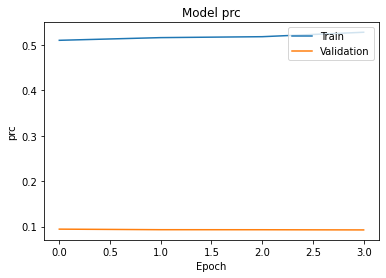

In [698]:
plot_history(resampled_history)

## Tuning the model

## Prediction with best model

In [699]:
test_df = pd.read_csv('data/test.csv')
test_df = test_df.drop('Loan Status',axis=1)

In [700]:
test_df= preprocess(test_df)

In [701]:
submission_df= pd.DataFrame(xgb_model.predict(test_df),columns=["Loan Status"])

In [702]:
submission_df.to_csv('my_submission_file.csv', index=False)